# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


import os
import json
from random import shuffle

import torch as th
import torchvision.transforms as transforms
import pytorch_lightning as pl

In [2]:
class Config:
    wording_dir = os.path.abspath('../')
    data_dir = os.path.abspath('../data')
    train_images_dir = os.path.abspath('../data/train_images')
    test_images_dir = os.path.abspath('../data/test_images')
    train_batch_size = 32
    test_batch_size = 16
    lr = 1e-4
    num_epochs = 30
    n_folds = 5
    models_dir = os.path.join(os.path.abspath('../'), 'models')
    logs_dir = os.path.join(os.path.abspath('../working'), 'logs')
    submissions_dir = os.path.join(os.path.abspath('../'), 'submissions')
    device = 'cuda'
    img_size = 300
    n_channels = 3
    base_model = 'resnet50'
    freeze = False
    precision = 16

# Eda part

In [3]:
train_df = pd.read_csv(os.path.join(Config.data_dir, 'train.csv'))
ss = pd.read_csv(os.path.join(Config.submissions_dir, 'sample_submission.csv'))

In [4]:
train_df.head(3)

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1


In [5]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
label,21397.0,2.651914,0.988565,0.0,2.0,3.0,3.0,4.0


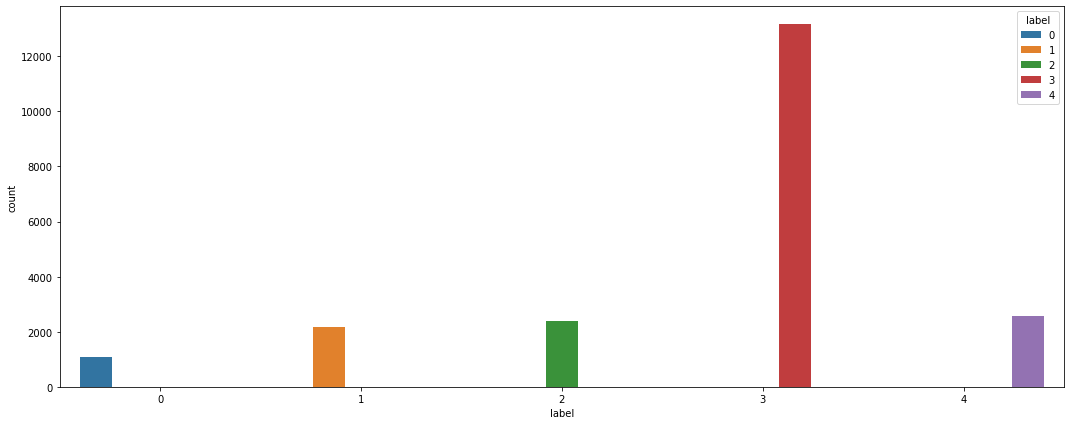

In [6]:
plt.figure(figsize=(18, 7))
sns.countplot(data=train_df, hue="label", x='label')
# or just do 
#train_df.label.hist()
plt.show()


In [7]:
labels_obj = open(os.path.join(Config.data_dir, 'label_num_to_disease_map.json'), )
labels_map = json.load(labels_obj)
#labels_map

In [8]:
classes = list(labels_map.values())
classes

['Cassava Bacterial Blight (CBB)',
 'Cassava Brown Streak Disease (CBSD)',
 'Cassava Green Mottle (CGM)',
 'Cassava Mosaic Disease (CMD)',
 'Healthy']

# Data module

In [9]:
data_transforms = {
    'train':th.nn.Sequential(
            transforms.Resize((Config.img_size, Config.img_size)),
            transforms.RandomHorizontalFlip(p=.6),
            transforms.RandomVerticalFlip(p=.3),
            transforms.GaussianBlur(3),
            #transforms.ToTensor()
        ),
    'test':th.nn.Sequential(
            transforms.Resize((Config.img_size, Config.img_size)),
            transforms.RandomVerticalFlip(p=.3),
            #transforms.ToTensor()

        )
}

In [10]:
from dataset import CassavaDM

In [12]:
dm = CassavaDM(
    df = train_df, 
    frac=1,
    n_classes=len(classes), 
    data_transforms=data_transforms, 
    train_data_dir=Config.train_images_dir,
    test_data_dir=Config.test_images_dir)

dm.setup()

[INFO] Training on 19257 samples belonging to 5 classes
[INFO] Validating on 2140 samples belonging to 5 classes


In [13]:
for data in dm.train_dataloader():
    print(data['images'].shape)
    break

torch.Size([64, 3, 300, 300])


# Data viz

In [14]:
def denormalize(img:th.tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    img = img.numpy().transpose((1, 2, 0))
    #mean = np.array(mean)
    #std = np.array(std)
    #img = std * img + mean
    img = np.clip(img, 0, 1)
    
    return img
    
    
def show_sample( dataset:th.utils.data.Dataset, size = 5, denorm=True):
    
    plt.figure(figsize=(size*size, size*3))
    for idx, data in enumerate(dataset):
        img, target = data['images'], data['targets']
        if denorm:
            img = denormalize(img)
        else:
            img = np.clip(img, 0, 1)
            
        label = classes[target]
        ax = plt.subplot(size, size, idx+1)
        plt.imshow(img)
        plt.title(label)
        plt.axis("off")

        if idx == size**2 - 1:
            break
   

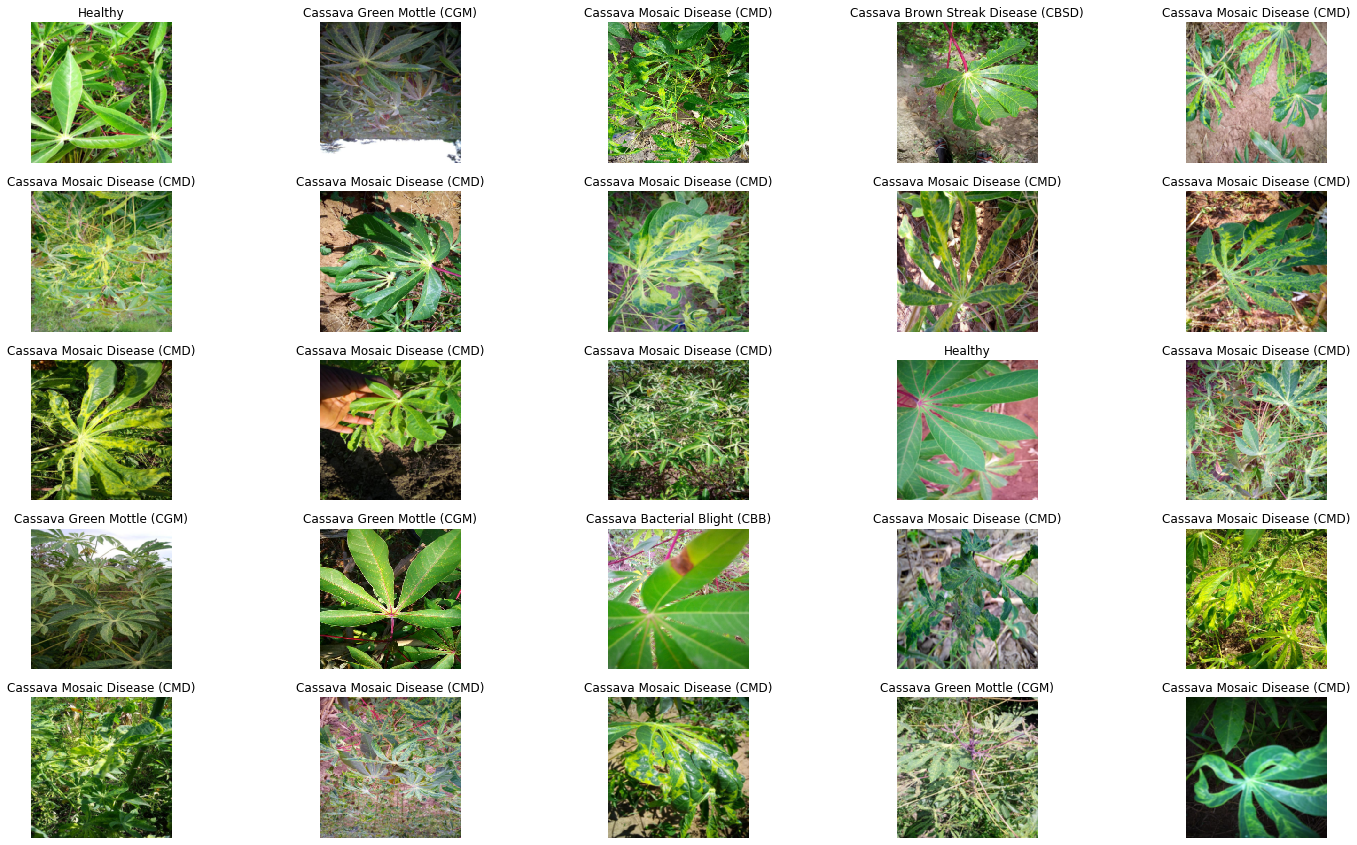

In [16]:
show_sample(dataset=dm.train_ds)